# Improved EDA on Kepler Objects of Interest Dataset
***Matt Paterson, hello@hireMattPaterson.com***<br>
**General Assembly, DSI-12, 2020**


This notebook reads in a ready-to-run dataset from NASA's Kepler Objects of Interest dataset which is uploaded to this github repo and exists in the data folder. 

In this notebook we take the raw data and try to find what is needed for a more accurate predictive model. It should be noted that the baseline models are pretty accurate already.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import lebowski, my custom Python Library for EDA
import lebowski as dude
# import autoreload in case I create new lebowski funcitons
import autoreload  

# Libraries needed for Logistic Regression and RandomForestClassifier

from sklearn.linear_model        import LogisticRegression
from sklearn.ensemble            import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection     import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing       import StandardScaler
from sklearn                     import metrics
from sklearn.metrics             import plot_confusion_matrix

# Libraries needed for Recurrent Neural Network

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [1]:
path_to_home = '../../'
datapath = path_to_home + 'data/'

In [3]:
df = pd.read_csv(datapath + 'dirty_kepler.csv')
df.head()

,kepid,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,12168280,2,0,0,0,0,229.957537,0.006730,-0.006730,326.01840,...,-83.0,3.978,0.195,-0.120,2.057,0.365,-0.501,295.97794,50.771481,10.505
1,11923074,0,0,0,0,1,1.756471,0.000015,-0.000015,132.02757,...,-157.0,4.561,0.033,-0.176,0.833,0.227,-0.071,296.14072,50.279949,14.723
2,11867733,0,0,1,0,0,384.356448,0.003680,-0.003680,298.90354,...,-193.0,4.445,0.067,-0.202,0.994,0.291,-0.125,293.77362,50.124470,14.391
3,10585887,0,1,0,0,0,378.654840,0.022800,-0.022800,288.25840,...,-209.0,4.463,0.070,-0.210,0.970,0.306,-0.123,285.24338,47.812592,14.872
4,10532751,0,1,0,0,0,367.761848,0.006750,-0.006750,194.76970,...,-295.0,2.897,0.045,-0.014,9.888,0.257,-2.058,290.87155,47.753368,10.736


## Do the flags indicate the planet's disposition?

Recall that koi_disposition equals 0 for 'Fals Positive', or not an exoplanet, 1 for 'Confirmed' as an exoplanet, or 2 for 'Candidate'. We want to eliminate columns in the dataset that will be harmful to prediction and create columns that might prove more helpful.

What do the four flag columns say about the kisposition column?


In [4]:
flags = ['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']

In [5]:
df[flags].groupby('koi_disposition').sum()

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec
koi_disposition,,,,
0,1135,2106,1779,1093
1,466,14,0,0
2,1,2,0,0


We see that the majority of the observations that contain flags have been deemed to not be exoplanets. Only 3 of 2245 observations that are still candidates have any flags at all.

In [6]:
df['koi_disposition'].value_counts()

0    4214
1    2285
2    2245
Name: koi_disposition, dtype: int64

In [7]:
df[flags].corr()

,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec
koi_disposition,1.000000,-0.021399,-0.523012,-0.472108,-0.353074
koi_fpflag_nt,-0.021399,1.000000,-0.020494,-0.002847,0.002204
koi_fpflag_ss,-0.523012,-0.020494,1.000000,0.145303,0.088528
koi_fpflag_co,-0.472108,-0.002847,0.145303,1.000000,0.531398
koi_fpflag_ec,-0.353074,0.002204,0.088528,0.531398,1.000000


The above table shows the correlation between each flag and the koi_disposition...and each other. Below we can see a heatmap visualization of the same.

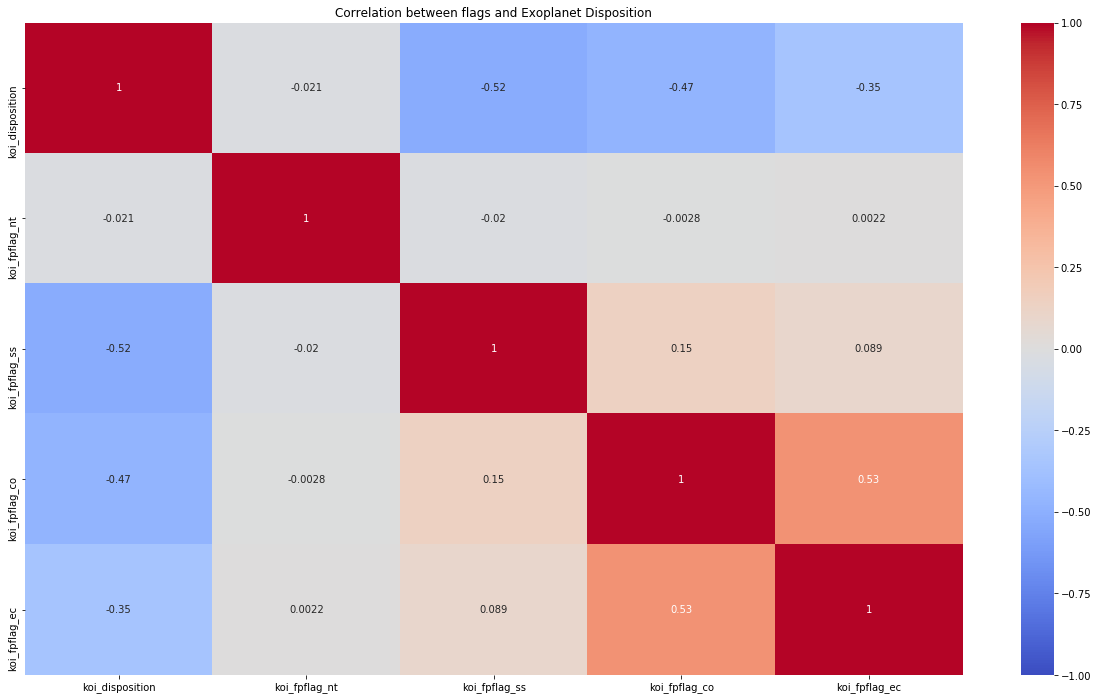

In [8]:
dude.heatmap_this(df, flags, 'Correlation between flags and Exoplanet Disposition')

Here we can see a fairly strong positive correlation between koi_fpflag_co and koi_fpflag_ec, and an equally strong negative correlation between koi_fpflag_ss and koi_disposition.

_co and _ec stand for Centroid Offset Flag and Ephemeris Match Indicates Contamination Flag respectively.

_ss stands for Stellar Eclipse Flag.

The Stellar Eclipse Flag is set for observations that have been deemed to have been caused by some sort of eclipse of the star that is most likely caused by another star.  This is why the negative correlation is so strong, because it is a column marked by the researchers to weed out false positives in their initial candidate field.

The other two are indicators of anomalies in the data resulting from errors in the technology.

To conclude, we'll delete all of the flag columns becuase they are used by the researchers that compiled this dataset to idicate whether or not they had found the expolanets. They are instructive to us to see why each observation was labled, but will not help our algorithm to label future data that have zero's in these fields.

In [9]:
flags.remove('koi_disposition')

In [10]:
df = df.drop(columns=flags)

In [11]:
df.shape

(8744, 38)

In [12]:
df.set_index('kepid', inplace=True)

In [13]:
candidates = df[df['koi_disposition'] == 2]
candidates.head()

,koi_disposition,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
kepid,,,,,,,,,,,,,,,,,,,,,
12168280,2,229.957537,0.006730,-0.006730,326.01840,0.01510,-0.01510,1.175,74.310,-4.203,...,-83.0,3.978,0.195,-0.120,2.057,0.365,-0.501,295.97794,50.771481,10.505
9592621,2,191.037280,0.013200,-0.013200,153.91070,0.06480,-0.06480,0.091,0.456,-0.091,...,-180.0,4.497,0.055,-0.165,0.901,0.213,-0.091,293.68390,46.265541,16.652
9159288,2,66.673050,0.012400,-0.012400,161.59000,0.17600,-0.17600,0.415,0.049,-0.415,...,-256.0,4.369,0.072,-0.217,1.190,0.404,-0.135,293.68979,45.549332,14.634
9011955,2,367.089600,0.022800,-0.022800,178.67440,0.04220,-0.04220,1.242,72.990,-3.631,...,-260.0,4.429,0.058,-0.232,1.100,0.384,-0.128,287.86737,45.321289,15.267
8673511,2,0.757261,0.000004,-0.000004,131.62154,0.00472,-0.00472,0.322,0.190,-0.321,...,-171.0,4.479,0.062,-0.200,0.953,0.279,-0.093,284.29565,44.895859,14.024


In [14]:
df = df[df['koi_disposition'] != 2] 

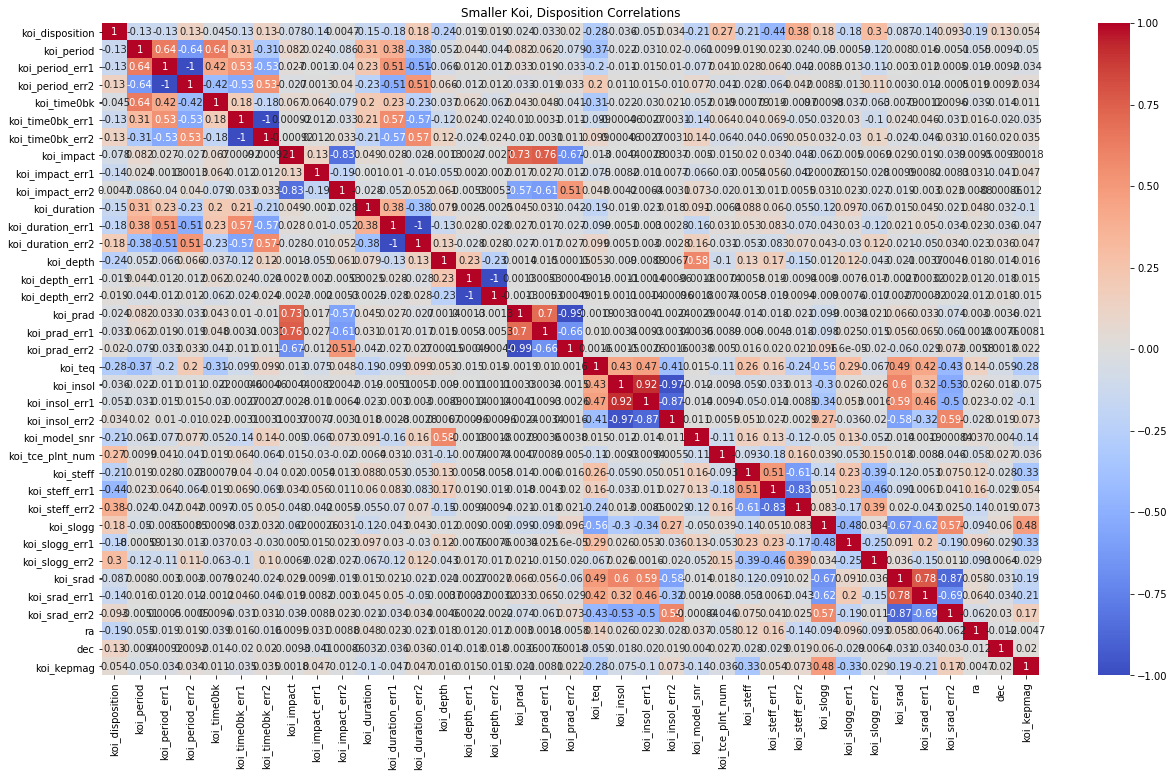

In [15]:
dude.heatmap_this(df, df.columns, 'Smaller Koi, Disposition Correlations')

## We don't have any strong correlations
**Let's get a new baseline Logistic Regression Model before we start adjusting columns**

In [16]:
lr = LogisticRegression()
X_train, X_train_sc, X_val, X_val_sc, y_train, y_val = dude.scaled_data_split(df, 'koi_disposition')
lr.fit(X_train_sc, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
lr.score(X_train_sc, y_train)

0.9217157145604924

In [18]:
lr.score(X_val_sc, y_val)

0.9207692307692308

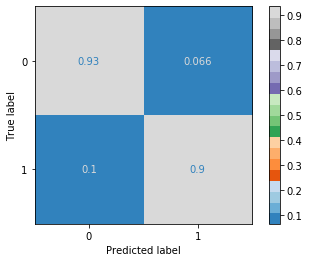

In [19]:
plot_confusion_matrix(lr, X_val_sc, y_val, normalize='true', cmap='tab20c');

Our simple Logistic Regression model has a baseline of 92% accuracy with about 10% false positives (that is objects our model predicts to be exoplanets but are actullay known to not be exoplanets, not to be confused with the KOI disposition of 'false positive'). That's pretty good, considering our sample has a split of 35% known exoplanets versus 65% known non-exoplanet observations.

Now let's mess with our datasets and try some more models.

## Since there are no strong correlations, let's look at the strongest correlations

In [20]:
df.corr()['koi_disposition'].sort_values(ascending=False)[1:11]


koi_steff_err2       0.383221
koi_slogg_err2       0.299148
koi_tce_plnt_num     0.273228
koi_duration_err2    0.184021
koi_slogg            0.176609
koi_period_err2      0.133796
koi_time0bk_err2     0.132515
dec                  0.128170
koi_srad_err2        0.092855
koi_kepmag           0.054105
Name: koi_disposition, dtype: float64

In [21]:
df.corr()['koi_disposition'].sort_values(ascending=True)[0:11]

koi_steff_err1      -0.444002
koi_teq             -0.280370
koi_depth           -0.237222
koi_steff           -0.214034
koi_model_snr       -0.208750
ra                  -0.189946
koi_duration_err1   -0.184021
koi_slogg_err1      -0.181628
koi_duration        -0.150347
koi_impact_err1     -0.138214
koi_srad_err1       -0.137713
Name: koi_disposition, dtype: float64

Above we see the top ten most positively and ten most negatively correlated columns from the KOI dataset as they relate to the koi_disposition.  Take some time to really familiarize yourself with each column as it is shown in the data dictionary, found here:  https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

The koi_steff_err2 is the negative poriton of the uncertainty of the photospheric temperature of the star.

The the negative poriton of the uncertainty of the photospheric temperature of the star ranges from an error of 0.0 to -1762.0 Kelvin


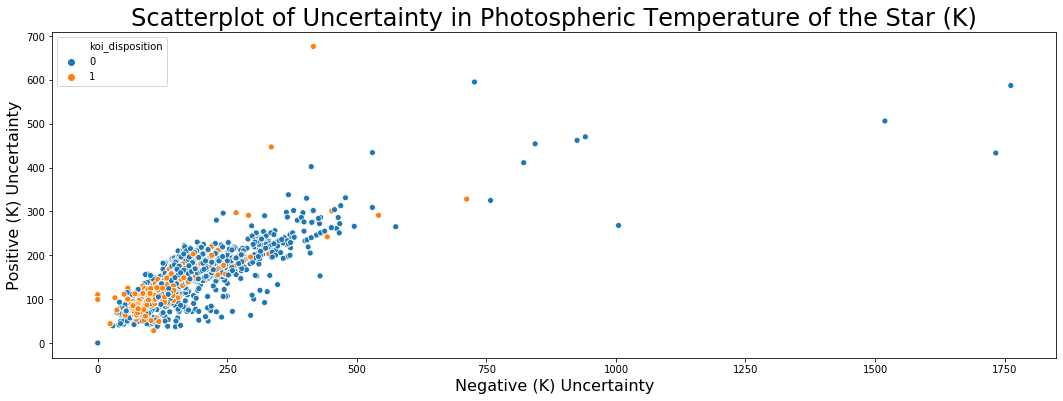

In [22]:
var = 'the negative poriton of the uncertainty of the photospheric temperature of the star'
top = df.koi_steff_err2.max()
bottom = df.koi_steff_err2.min()
print(f'The {var} ranges from an error of {top} to {bottom} Kelvin')

plt.figure(figsize=(18, 6))
sns.scatterplot(-1* df.koi_steff_err2, df.koi_steff_err1, hue=df.koi_disposition)

plt.xlabel('Negative (K) Uncertainty', fontsize=16)
plt.ylabel('Positive (K) Uncertainty', fontsize=16)

plt.title('Scatterplot of Uncertainty in Photospheric Temperature of the Star (K)',
         fontsize=24);

It is hard to guess at why the range of uncertainty of the temperature of the surface of the star is strongly correlated to the disposition of the transiting object; ie why is that correlated with how sure we are about the presence of an exoplanet? 

It is possible that in areas of the the interstellar neighborhood where we are more certain of the Photospheric Temperature of the Star, we are also more certain that objects of interest that we observed in the Kepler project telescope are in fact exoplanets.

We can see that there is a definite cluster of values seen in the dataset, with the exoplanet class (1) clustering fairly well near the zero error.

***NEXT***<br>
The koi_slogg_err2 represents the base-10 logarithm of the acceleration due to gravity at the surface of the star.

The the base-10 logarithm of the acceleration due to gravity at the surface of the star ranges from an error of 0.0 to -1.007


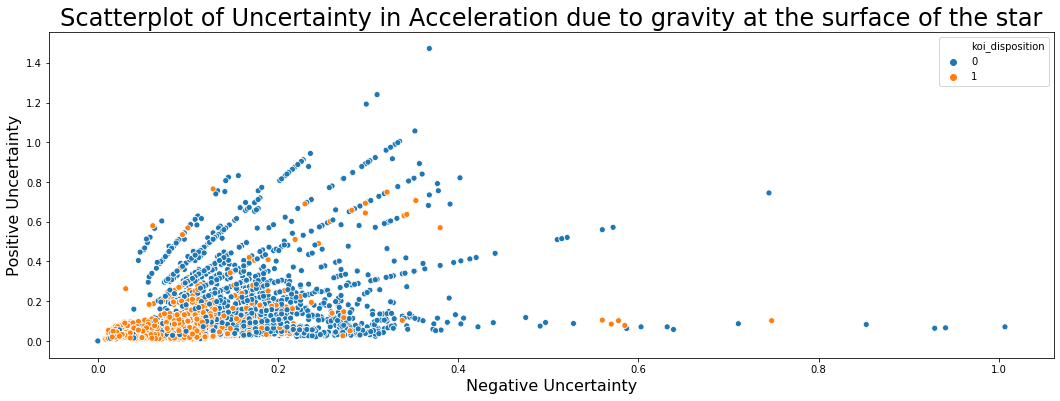

In [23]:
var = 'the base-10 logarithm of the acceleration due to gravity at the surface of the star'
top = df.koi_slogg_err2.max()
bottom = df.koi_slogg_err2.min()
print(f'The {var} ranges from an error of {top} to {bottom}')

plt.figure(figsize=(18, 6))
sns.scatterplot(-1* df.koi_slogg_err2, df.koi_slogg_err1, hue=df.koi_disposition)

plt.xlabel('Negative Uncertainty', fontsize=16)
plt.ylabel('Positive Uncertainty', fontsize=16)

plt.title('Scatterplot of Uncertainty in Acceleration due to gravity at the surface of the star',
         fontsize=24);

Again we see an unmistakeable clustering of positive exoplanet designations around the zero error

***NEXT***<br>
The koi_duration_err2 is the negative uncertainty in the duration of the observed transits. According to the caltech KOI data dictionary, the Transit Duration is calculated in hours and found by using the "Mandel-Agol (2002) model fit to a multi-quarter Kepler light curve, assuming a linear orbital ephemeris"

The the uncertainty in the duration of the observed transits ranges from an error of 0.0 to -20.2


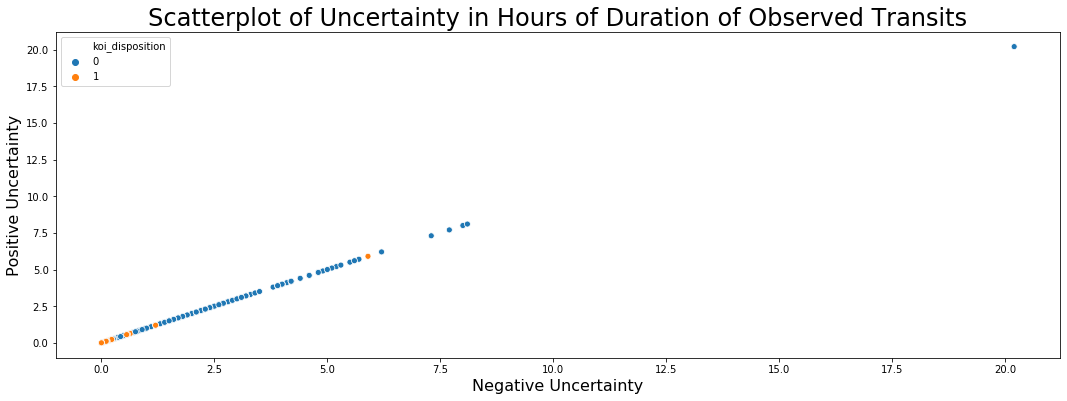

In [24]:
var = 'the uncertainty in the duration of the observed transits'
top = df.koi_duration_err2.max()
bottom = df.koi_duration_err2.min()
print(f'The {var} ranges from an error of {top} to {bottom}')

plt.figure(figsize=(18, 6))
sns.scatterplot(-1* df.koi_duration_err2, df.koi_duration_err1, hue=df.koi_disposition)

plt.xlabel('Negative Uncertainty', fontsize=16)
plt.ylabel('Positive Uncertainty', fontsize=16)

plt.title('Scatterplot of Uncertainty in Hours of Duration of Observed Transits',
         fontsize=24);

## Certainty is...well, certain. 
It is intuitively obvious that for the above three measures, we are seeing that if we have more scientific certainty about the star, then any transits that we observe near that star that end up on the Kepler Objects of Interest table are inherently more certain as well. Thus, it stands to reason that there would be fewer observations that fit the criteria to end up on this list that end up being proved to be anomolies or errant entries.

***NEXT***<br>
Next we see that the koi_tce_plnt_num has a 27% positive correlation to the exoplanetary designation. This is certainly an anomoly as this column is the TCE Planet Number federated to teh KOI, and is not a measurement at all. We will drop this from the dataset.

In [25]:
df = df.drop(columns='koi_tce_plnt_num')

## Also Mentioned...
The koi_slogg measurement, again the Stellar Surface Gravity, measured as log base 10 centimeters per second squared, has a very weak but present positive correlation to the koi_disposition

The logarithm of Stellar Surface Gravity ranges from 5.283 to 0.047 log-base-10 centimeters per second squared


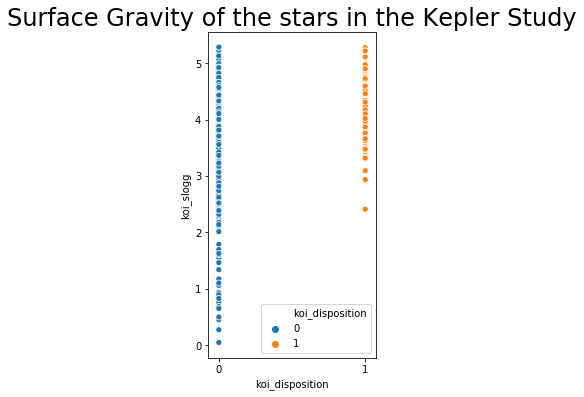

In [26]:
var = 'logarithm of Stellar Surface Gravity'
top = df.koi_slogg.max()
bottom = df.koi_slogg.min()
print(f'The {var} ranges from {top} to {bottom} log-base-10 centimeters per second squared')

plt.figure(figsize=(3, 6))
#sns.scatterplot(data=df.koi_slogg[df.koi_disposition==1], hue=df.koi_disposition, label='exoplanet', color='orange')
sns.scatterplot(df.koi_disposition, df.koi_slogg, hue=df.koi_disposition)

#plt.plot(df.koi_slogg)
plt.xticks([0, 1])
plt.title('Surface Gravity of the stars in the Kepler Study', fontsize=24)
plt.legend();

This is, again, a very weak positive correlation, as we can see a lot of overlap in the classes, but clearly if the surface gravity is below 2.5 or so, we see there are no "confirmed" exoplanets.

## Look closely at the top five negatively correlated features

In [27]:
df.corr()['koi_disposition'].sort_values(ascending=True)[1:6]

koi_teq         -0.280370
koi_depth       -0.237222
koi_steff       -0.214034
koi_model_snr   -0.208750
ra              -0.189946
Name: koi_disposition, dtype: float64

In reverse order, we have the Right Ascension, which paired with the Declination helps us to map the star and our KOI observation in the sky; the Transit Signal-to-Noise ratio, the acutal Stellar Effective Temperature (measured in Kelvin), Transit Depth measured in parts per million, and the Equilibrium Temperature of the exoplanet (measured in Kelvin).

According to CalTech, the Transit Depth is "the fraction of stellar flux lost at the minimum of the planetary transit. Transit depths are typically computed from a best-fit model produced by a Mandel-Agol (2002) model fit to a multi-quarter Kepler light curve, assuming a linear orbital ephemeris."  

Quoting from that same data dictionary, the Equilibrium Temperature is the "Approximation for the temperature of the planet. The calculation of equilibrium temperature assumes a) thermodynamic equilibrium between the incident stellar flux and the radiated heat from the planet, b) a Bond albedo (the fraction of total power incident upon the planet scattered back into space) of 0.3, c) the planet and star are blackbodies, and d) the heat is evenly distributed between the day and night sides of the planet."

## Negative Correlations Graphed:

The Equilibrium Temperature ranges from 14667.0 to 92.0 log-base-10 centimeters per second squared


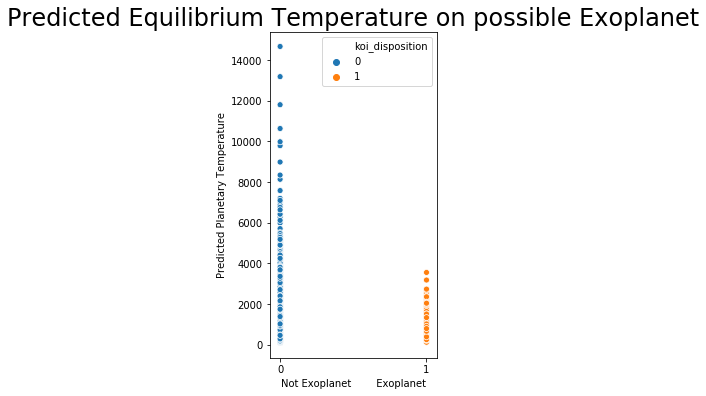

In [28]:
var = 'Equilibrium Temperature'
top = df.koi_teq.max()
bottom = df.koi_teq.min()
print(f'The {var} ranges from {top} to {bottom} log-base-10 centimeters per second squared')

plt.figure(figsize=(3, 6))
#sns.scatterplot(data=df.koi_slogg[df.koi_disposition==1], hue=df.koi_disposition, label='exoplanet', color='orange')
sns.scatterplot(df.koi_disposition, df.koi_teq, hue=df.koi_disposition)

#plt.plot(df.koi_slogg)
plt.xticks([0, 1])
plt.xlabel('Not Exoplanet        Exoplanet')
plt.ylabel('Predicted Planetary Temperature')
plt.title('Predicted Equilibrium Temperature on possible Exoplanet', fontsize=24)
plt.legend();

We clearly see here that a predicted Equilibrium Planetary temperature has to be less than 4000 K to be classified as an exoplanet.

***NEXT***<br>
Next look at the Transit Depth

The Transit Depth ranges from 1540000.0 to 4.5 log-base-10 centimeters per second squared


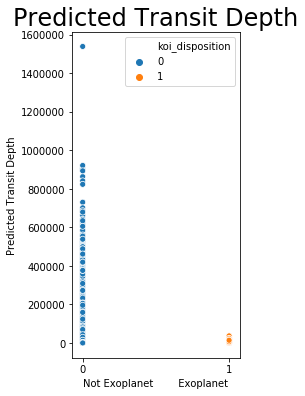

In [29]:
var = 'Transit Depth'
top = df.koi_depth.max()
bottom = df.koi_depth.min()
print(f'The {var} ranges from {top} to {bottom} log-base-10 centimeters per second squared')

plt.figure(figsize=(3, 6))
#sns.scatterplot(data=df.koi_slogg[df.koi_disposition==1], hue=df.koi_disposition, label='exoplanet', color='orange')
sns.scatterplot(df.koi_disposition, df.koi_depth, hue=df.koi_disposition)

#plt.plot(df.koi_slogg)
plt.xticks([0, 1])
plt.xlabel('Not Exoplanet        Exoplanet')
plt.ylabel('Predicted Transit Depth')
plt.title('Predicted Transit Depth', fontsize=24)
plt.legend();

Again we see all of the exoplanets cluster around the lower bound of Transit Depth

***NEXT***<br>
Stellar Effective Temperature

The Stellar Effective Temperature ranges from 15896.0 to 2661.0 log-base-10 centimeters per second squared


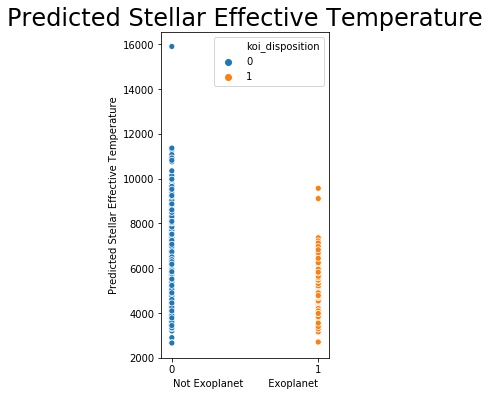

In [30]:
var = 'Stellar Effective Temperature'
top = df.koi_steff.max()
bottom = df.koi_steff.min()
print(f'The {var} ranges from {top} to {bottom} log-base-10 centimeters per second squared')

plt.figure(figsize=(3, 6))
#sns.scatterplot(data=df.koi_slogg[df.koi_disposition==1], hue=df.koi_disposition, label='exoplanet', color='orange')
sns.scatterplot(df.koi_disposition, df.koi_steff, hue=df.koi_disposition)

#plt.plot(df.koi_slogg)
plt.xticks([0, 1])
plt.xlabel('Not Exoplanet        Exoplanet')
plt.ylabel('Predicted Stellar Effective Temperature')
plt.title('Predicted Stellar Effective Temperature', fontsize=24)
plt.legend();

The already-weak negative correlations are getting weaker as we can see a LOT of overlap in this chart too.

Given the absence of any very strong correlations, we've looked at some of the top weak correlations and can try to take the top ten features from these correlation tables and compare a confusion matrix of it to the original Logistic Regression model.

In [31]:
limited_features = list(df.corr()['koi_disposition'].sort_values(ascending=True)[0:6].keys())
for feat in list(df.corr()['koi_disposition'].sort_values(ascending=False)[1:6].keys()):
    limited_features.append(feat)
limited_features.append('koi_disposition')

In [32]:
limited_df = df[limited_features]

## Make our second Logistic Regression model, called lr2

In [33]:
lr2 = LogisticRegression()
X_lim_train, X_lim_train_sc, X_lim_val, X_lim_val_sc, y_lim_train, y_lim_val = dude.scaled_data_split(limited_df, 
                                                                                                      'koi_disposition')
lr2.fit(X_lim_train_sc, y_lim_train)



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
print('Scores Comparrisson:')
print('*'*40)
print('smaller feature training score  :', lr2.score(X_lim_train_sc, y_lim_train))
print('Original Model training score   :', lr.score(X_train_sc, y_train))

print('smaller feature validation score:', lr2.score(X_lim_val_sc, y_lim_val))
print('Original Model validation score :', lr.score(X_val_sc, y_val))


Scores Comparrisson:
****************************************
smaller feature training score  : 0.8778611271398346
Original Model training score   : 0.9217157145604924
smaller feature validation score: 0.8746153846153846
Original Model validation score : 0.9207692307692308


In [35]:
y_pred = lr2.predict(X_lim_val_sc)
metrics.confusion_matrix(y_lim_val, y_pred, 
                         normalize=None)

array([[768,  75],
       [ 88, 369]], dtype=int64)

True Negatives: 768
False Negatives: 88

False Positives: 75
True Positives: 369
Sensitivity : 0.8074398249452954
Specificity : 0.9110320284697508


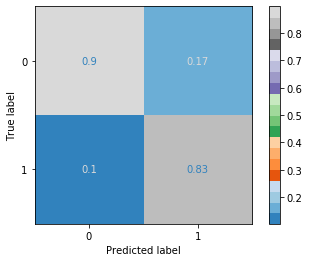

In [36]:
# This code improved from Matt Brems lesson in General Assembly
tn, fp, fn, tp = metrics.confusion_matrix(y_lim_val, y_pred).ravel()
print("True Negatives: " + str(tn))
print("False Negatives: " + str(fn))
print()
print("False Positives: " + str(fp))
print("True Positives: " + str(tp))

sensitivity = tp / (tp+fn)
print(f'Sensitivity : {sensitivity}')
specificity = tn / (tn+fp)
print(f'Specificity : {specificity}')

plot_confusion_matrix(lr2, X_lim_val_sc, y_lim_val, normalize='pred', cmap='tab20c');

Clearly, by limiting our field of features to only the 10 strongest correlated features, we only served to weaken our prediction engine AND to decrease our Sensitivity and Specificity. In other words, this more limited feature did not improve our predictions.

## Create lr3, a Logistic Regression using the original set minus the newly deleted columns

training score:  0.9207539911521446
validation score:  0.9138461538461539


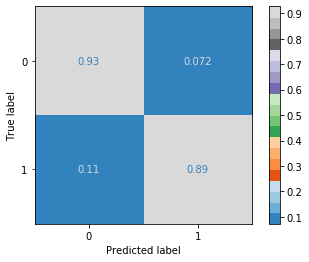

In [37]:
lr3 = LogisticRegression()
X_train, X_train_sc, X_val, X_val_sc, y_train, y_val = dude.scaled_data_split(df, 'koi_disposition')
lr3.fit(X_train_sc, y_train)

print('training score: ', lr3.score(X_train_sc, y_train))
print('validation score: ', lr3.score(X_val_sc, y_val))
plot_confusion_matrix(lr3, X_val_sc, y_val, normalize='true', cmap='tab20c');

Still somehow this model is slightly more overfit versus the original, but it's likely that we were predicting on noise in that first model anyway, given that the deleted column was an ID number, so this is really a model that should perform better on unknown data.

In [38]:
# Show all columns used for this last model iteration
df.columns

Index(['koi_disposition', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

## Create a Random Forest Classifier
Random Forest Classifier employs a bagging process on a decision tree classifier, both bootstrapping (or resampling) and aggregating various decision trees to come up with the most likely predictions of the classes.

In [39]:
X_train, X_train_sc, X_val, X_val_sc, y_train, y_val = dude.scaled_data_split(dataframe=df, target='koi_disposition')

In [40]:
rf = RandomForestClassifier()
rf.fit(X_train_sc, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
print('Training Score: ', rf.score(X_train_sc, y_train))
print('Validation Score: ', rf.score(X_val_sc, y_val))

Training Score:  1.0
Validation Score:  0.9384615384615385


It's still mind boggling that this RandomForestClassifier can be so accurate when there are no strong data correlations in the original dataset. We should look at the confusion matrix and see what we see.

In [42]:
y_pred = rf.predict(X_val_sc)

In [43]:
metrics.confusion_matrix(y_val, y_pred, 
                         normalize=None)

array([[804,  39],
       [ 41, 416]], dtype=int64)

In [44]:
# This code improved from Matt Brems lesson in General Assembly
tn, fp, fn, tp = metrics.confusion_matrix(y_val, y_pred).ravel()
print("True Negatives: " + str(tn))
print("False Negatives: " + str(fn))
print()
print("False Positives: " + str(fp))
print("True Positives: " + str(tp))


True Negatives: 804
False Negatives: 41

False Positives: 39
True Positives: 416


In [45]:
sensitivity = tp / (tp+fn)
print(f'Sensitivity : {sensitivity}')
specificity = tn / (tn+fp)
print(f'Specificity : {specificity}')

Sensitivity : 0.9102844638949672
Specificity : 0.9537366548042705


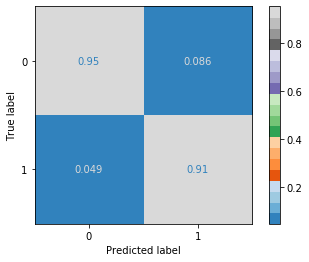

In [46]:
plot_confusion_matrix(rf, X_val_sc, y_val, normalize='pred', cmap='tab20c');

We can see that the model did a pretty good job at predicting our ground truth, with a Sensitivity of either 92%, or 90.4%, and a Specificity of 95.7%.

For the sake of assuredness, I can even weight these predictions when I'm more sure of the model, so that I have a lower number--even zero--of false positives. This way, I might miss some exoplanets, but I won't falsely predict any.

In [47]:
ss = StandardScaler()

Fit the candidates data to the Standard Scaler

In [48]:
candidates = candidates[list(df.columns)]

In [49]:
test = candidates.drop(columns='koi_disposition')

In [50]:
ss.fit(X_train)
test_sc = ss.transform(test)

In [51]:
candidates['exoplanet'] = rf.predict(test_sc)

In [52]:
candidates.exoplanet.value_counts()

0    1446
1     799
Name: exoplanet, dtype: int64

If this model is predicting accurately, we have just identified about 725 new exoplanets, given that our model predicted 805 out of 2245 observations to be exoplanets and has a sensitivity of aobut 90%

## Create RNN
In an earlier iteration, we created a recurrent neural network on our dirty data. How will the RNN preform on the new data?

In [53]:
X_train_sc.shape

(5199, 35)

In [54]:
# Use the same RNN that we built prior as a "baseline", 
# but change the first layer to have the same number of 
# nodes as input features

rnn = Sequential()
rnn.add(Dense(36, input_dim=X_train.shape[1], activation='relu'))
rnn.add(Dense(16, activation='relu'))
rnn.add(Dense(1, activation='sigmoid'))

rnn.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc']) # loss = 'bce'

history_rnn = rnn.fit(
    X_train_sc,
    y_train,
    validation_data=(X_val_sc, y_val),
    epochs=100,
    batch_size=None,
    verbose=2
)

Epoch 1/100
163/163 - 0s - loss: 0.4201 - acc: 0.8265 - val_loss: 0.3082 - val_acc: 0.8600
Epoch 2/100
163/163 - 0s - loss: 0.2784 - acc: 0.8938 - val_loss: 0.2457 - val_acc: 0.8969
Epoch 3/100
163/163 - 0s - loss: 0.2358 - acc: 0.9075 - val_loss: 0.2242 - val_acc: 0.9123
Epoch 4/100
163/163 - 0s - loss: 0.2116 - acc: 0.9181 - val_loss: 0.2125 - val_acc: 0.9185
Epoch 5/100
163/163 - 0s - loss: 0.1961 - acc: 0.9238 - val_loss: 0.2009 - val_acc: 0.9269
Epoch 6/100
163/163 - 0s - loss: 0.1822 - acc: 0.9302 - val_loss: 0.1919 - val_acc: 0.9292
Epoch 7/100
163/163 - 0s - loss: 0.1730 - acc: 0.9344 - val_loss: 0.1879 - val_acc: 0.9300
Epoch 8/100
163/163 - 0s - loss: 0.1667 - acc: 0.9361 - val_loss: 0.1839 - val_acc: 0.9346
Epoch 9/100
163/163 - 0s - loss: 0.1600 - acc: 0.9377 - val_loss: 0.1775 - val_acc: 0.9338
Epoch 10/100
163/163 - 0s - loss: 0.1556 - acc: 0.9423 - val_loss: 0.1764 - val_acc: 0.9377
Epoch 11/100
163/163 - 0s - loss: 0.1525 - acc: 0.9417 - val_loss: 0.1726 - val_acc: 0.93

Epoch 89/100
163/163 - 0s - loss: 0.0773 - acc: 0.9717 - val_loss: 0.1685 - val_acc: 0.9438
Epoch 90/100
163/163 - 0s - loss: 0.0775 - acc: 0.9711 - val_loss: 0.1732 - val_acc: 0.9423
Epoch 91/100
163/163 - 0s - loss: 0.0779 - acc: 0.9686 - val_loss: 0.1584 - val_acc: 0.9508
Epoch 92/100
163/163 - 0s - loss: 0.0780 - acc: 0.9690 - val_loss: 0.1599 - val_acc: 0.9469
Epoch 93/100
163/163 - 0s - loss: 0.0769 - acc: 0.9710 - val_loss: 0.1560 - val_acc: 0.9485
Epoch 94/100
163/163 - 0s - loss: 0.0745 - acc: 0.9725 - val_loss: 0.1550 - val_acc: 0.9508
Epoch 95/100
163/163 - 0s - loss: 0.0768 - acc: 0.9708 - val_loss: 0.1627 - val_acc: 0.9485
Epoch 96/100
163/163 - 0s - loss: 0.0750 - acc: 0.9711 - val_loss: 0.1632 - val_acc: 0.9492
Epoch 97/100
163/163 - 0s - loss: 0.0759 - acc: 0.9698 - val_loss: 0.1562 - val_acc: 0.9500
Epoch 98/100
163/163 - 0s - loss: 0.0741 - acc: 0.9717 - val_loss: 0.1630 - val_acc: 0.9469
Epoch 99/100
163/163 - 0s - loss: 0.0734 - acc: 0.9702 - val_loss: 0.1685 - val_

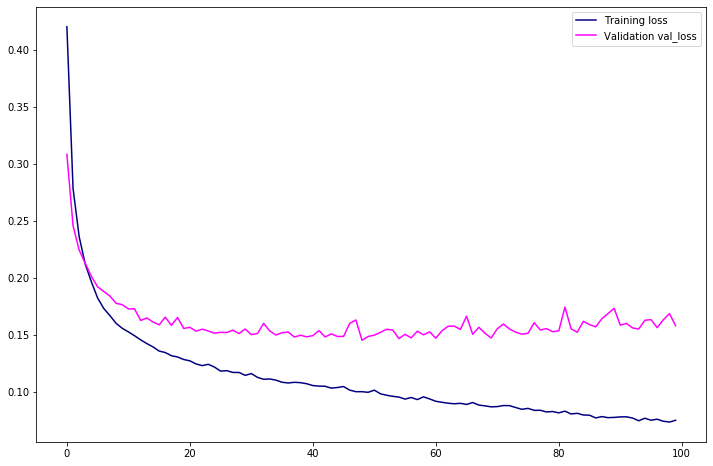

In [55]:
dude.display_metrics(history_rnn, 'loss')
#display_metrics(history_rnn, 'loss')

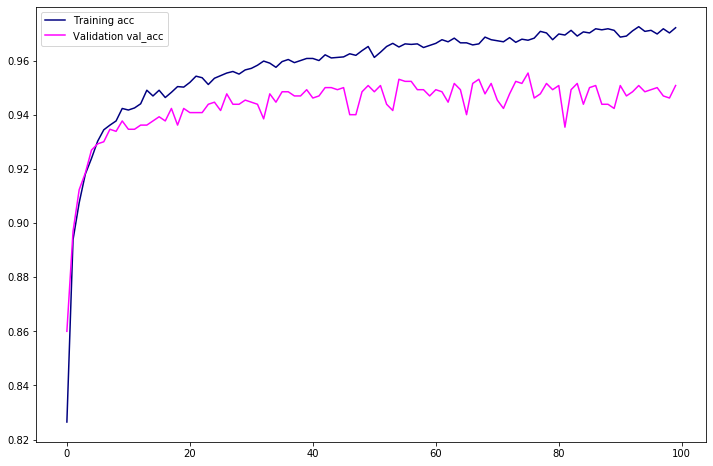

In [56]:
dude.display_metrics(history_rnn, 'acc')
#display_metrics(history_rnn, 'acc')

In [57]:
model_rnn_top_score = sorted(history_rnn.history['val_acc'], reverse=True)[0]
print(f'This model has a maximum accuracy score of {model_rnn_top_score}')

model_rnn_best_loss = sorted(history_rnn.history['val_loss'], reverse=False)[0]
print(f'This model has a minimum loss score of {model_rnn_best_loss}')

This model has a maximum accuracy score of 0.9553846120834351
This model has a minimum loss score of 0.14513680338859558


As we learned in the firts iteration, it looks like the Recurrent Neural Network Model performs best at around epoch 30. We also make a confusion matrix with the RNN results.

In [58]:
y_rnn_pred = rnn.predict_classes(X_val_sc)
metrics.confusion_matrix(y_val, y_rnn_pred, 
                         normalize=None)
# This code improved from Matt Brems lesson in General Assembly
tn, fp, fn, tp = metrics.confusion_matrix(y_val, y_rnn_pred).ravel()
print("True Negatives: " + str(tn))
print("False Negatives: " + str(fn))
print()
print("True Positives: " + str(tp))
print("False Positives: " + str(fp))
print("\n*************************\n")
sensitivity_rnn = tp / (tp+fn)
print(f'RNN Sensitivity : {sensitivity_rnn}')
print(f'RFC Sensitivity : {sensitivity}')
specificity_rnn = tn / (tn+fp)
print(f'RNN Specificity : {specificity_rnn}')
print(f'RFC Specificity : {specificity}')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
True Negatives: 810
False Negatives: 31

True Positives: 426
False Positives: 33

*************************

RNN Sensitivity : 0.9321663019693655
RFC Sensitivity : 0.9102844638949672
RNN Specificity : 0.9608540925266904
RFC Specificity : 0.9537366548042705


We see that the two models preform nearly the same on both Sensitivity and Specificity.  This is a good indicator of an accurate model.

In [59]:
candidates['exoplanet_rnn'] = rnn.predict_classes(test_sc)

In [60]:
candidates['exoplanet_rnn'].value_counts()

0    1302
1     943
Name: exoplanet_rnn, dtype: int64

So now we have two models using the same data, with slightly different Accuracy Scores, predicting a similar number of exoplanets. The next step will be to see which observations are predicted by both models.

In [61]:
overlap = candidates[['exoplanet', 'exoplanet_rnn']][(candidates['exoplanet']==1) | (candidates['exoplanet_rnn']==1)]
overlap.shape

(1042, 2)

In [62]:
overlap[(overlap.exoplanet == 1) & (overlap.exoplanet_rnn == 1)]

,exoplanet,exoplanet_rnn
kepid,,
6043538,1,1
12458817,1,1
11288772,1,1
10665749,1,1
10659624,1,1
...,...,...
7941200,1,1
8056665,1,1
7199397,1,1


## Add Predictions from the Logistic Regression model

In [63]:
candidates['exoplanet_lr3'] = lr3.predict(test_sc)
candidates['exoplanet_lr3'].value_counts()

0    1216
1    1029
Name: exoplanet_lr3, dtype: int64

We can now add this to the overlap table

In [64]:
overlap = candidates[['exoplanet', 'exoplanet_rnn', 'exoplanet_lr3']][(candidates['exoplanet']==1) | (candidates['exoplanet_rnn']==1) | (candidates['exoplanet_lr3']==1)]
overlap.shape

(1210, 3)

In [65]:
new_exoplanets = overlap[(overlap.exoplanet == 1) & (overlap.exoplanet_rnn == 1) & (overlap.exoplanet_lr3 == 1)]

In [66]:
new_exoplanets.shape

(662, 3)

## New results?
**We just ran three fairly accurate prediction models against a list of 2245 unclassified Kepler Objects of Interest, and have confidently found that 662 of these observations are predicte to be exoplanets in all three! I would like to adjust the probability threshold and try to eliminate false positives from the predictions that are made on the validation set, and then re-run the test to see how many exoplanets are then predicted, but for now this is a fairly confident model and should be put in to a python program for use.**

**We can additionaly look at the overlap between our confusion matricies, or in other words, we can see where each model predicted correctly against the ground truth and where the false-positives were. This can give us some insight in to what the model was misreading.**

**The next step is to start running the various other KOI dataset experiments, such as a Convoultional Neural Network on the time-series dataset, and seeing if the kepid's are the same accross our predictive results from the unknown Candidates. Then I will make confident predictions.**

## Factor in the probabilities where possible

Classification models such as Logistic Regression and Random Forest Classifier are able to tell us the probabilities that each row is or is not an exoplanet. Typically it uses this probability to make its prediction, with a probability above 50% being an exoplanet, and one below 50% being not an exoplanet. We can create a function to adjust the predictions and see if that can eliminate false positives from our predictive models.

## Conclusion:

We still need to take a look at how we can limit our predictions further, but as of now, we can be fairly confident that we have identified about 595 or more exoplanets given that our overlapping models agree on 662 of them with a 90% Sensitivity on two out of three models. 